# AdventureWorks fösälningsanalys
I denna analys undersöker vi AdventureWroks- databasen för att besvara affärsfrågor som exemplvis:
- Produktkategorier och deras försälning
- Försälningstrender över tid
- Regional försälning

Vi använder SQL för att hämta data och Pyhtonför visualisering och analys.

## Visualisering 1: Antal produkter per kategori
hur många produkter finns i varje kategori?

Tabeller som används:
Production.ProductCategory
Production.ProductSubCategory
Production.Product

Plan:
JOINA tabellerna
Räkna DISTINCT produkter per kategori
Skapa vertikalt stapeldiagram
Analysera resultatet

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import matplotlib.pyplot as plt
import numpy as np

user = "sa"
password = quote_plus("WM271290!")
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")

connection_string = f"mssql+pyodbc://{user}:{password}@{server}/{database}?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
engine = create_engine(connection_string)
 
try: 
    with engine.connect():
        print("Connection to the database was successful.")
except Exception as e:
    print("An error occurred while connecting to the database:", e)


def query_df(sql:str) -> pd.DataFrame:
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

Connection to the database was successful.


C:\Users\wendy\AppData\Local\Temp\ipykernel_2452\848119440.py:16: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


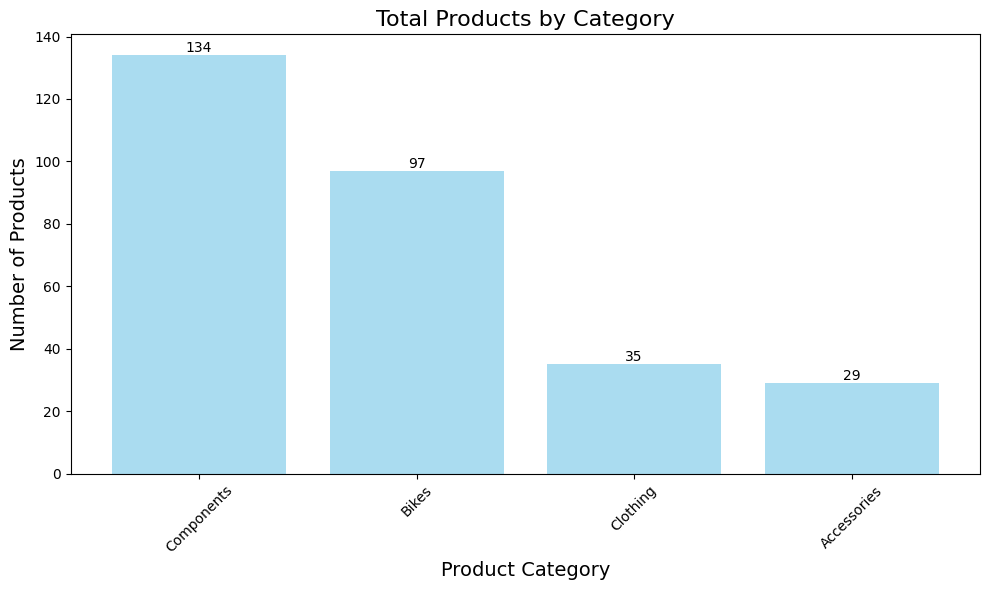

In [11]:
query_vis1 = """
SELECT 
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS TotalProducts

FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc 
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p 
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY TotalProducts DESC
"""

df_vis1 = query_df(query_vis1)
df_vis1

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df_vis1['CategoryName'], df_vis1['TotalProducts'], color='skyblue',alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

ax.set_title('Total Products by Category', fontsize=16)
ax.set_xlabel('Product Category', fontsize=14)
ax.set_ylabel('Number of Products', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Insikter - Antal produkt per kategori

Compoents är störasta kategorin med 134 produkter. Accessories är minst med 29 produkter.
Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar. Och att accessories kan vara ett utvecklingsområde.

## Visualisering 2: Försäljning per produktkategori
Vilka produktkategorier genererar mest intäkter?

Tabeller som används:
Production.ProductCategory
Production.ProductSubcategory
Production.Product
Sales.SalesOrderDetail

Plan:
JOINA tabellerna
Räkna intäker per produktkategori
Skapa horisontellt stapeldiagram
Analysera resultatet

,CategoryName,TotalRevenue,TotalQuantitySold
0,Accessories,1272072.88,61932
1,Clothing,2120542.52,73670
2,Components,11802593.29,49044
3,Bikes,94651172.70,90268


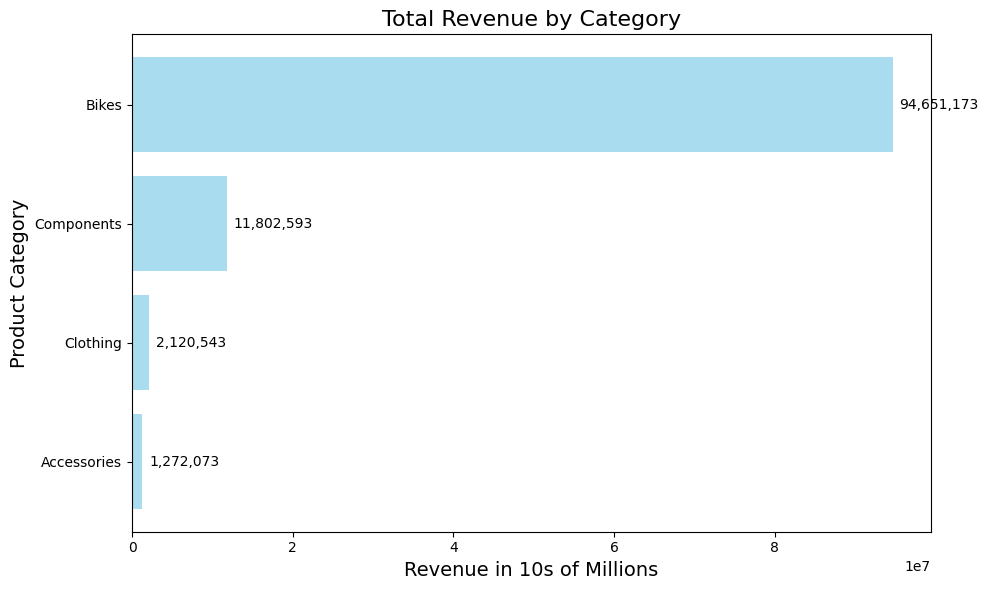

In [25]:
query_vis2 = """
SELECT 
    pc.Name AS CategoryName,
    round(SUM(LineTotal),2) AS TotalRevenue,
    SUM(OrderQty) AS TotalQuantitySold

FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc 
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p 
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN sales.SalesOrderDetail sod 
    ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalRevenue ASC;
"""


df_vis2 = query_df(query_vis2)
display(df_vis2)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df_vis2['CategoryName'], df_vis2['TotalRevenue'], color='skyblue',alpha=0.7,)

ax.bar_label(
    bars,
    labels=[f"{v:,.0f}" for v in df_vis2['TotalRevenue']],
    padding=5
)

ax.set_title('Total Revenue by Category', fontsize=16)
ax.set_ylabel('Product Category', fontsize=14)
ax.set_xlabel('Revenue in 10s of Millions', fontsize=14)
plt.tight_layout()
plt.show()

## Insikter - Försäljning per produktkategori

Bikes är störasta kategorin med 94,5 Mio intäkt. Accessories är minst med 1,3 Mio intäkt.

## Visualisering 3: Försäljningstrend över tid
Hur har försäljningen utvecklats över tid?

Tabeller som används:
Sales.SalesOrderHeader

Plan:
Räkna intäker per månader
Skapa Linjediagram
Analysera resultatet


Affärsfråga: 
Krav på data:
• Använd tabeller: 
• Aggregera per månad (minst 12 månader data)
• Sortera kronologiskt (äldst först)
Krav på visualisering:
• Typ:  (line plot)
• Titel: "Försäljningstrend per månad"
• Visa tydlig tidslinje på X-axeln
Krav på insikt:
• Beskriv trenden - ökar den, minskar den, är den säsongsberoende? Nämn högsta och lägsta månaden.


## Visualisering 4: Försäljning och antal ordrar per år
Hur ser total försäljning och antal ordrar ut per år?

Tabeller som används:
Sales.SalesOrderHeader

Plan:
Räkna intäker per år
Räkna antal ordrar per år
Skapa två separata staplar per år
Analysera resultatet

,Year,TotalOrders,TotalRevenue,AverageRevenuePerOrder
0,2025,11699,20008518.36,1710.2759
1,2024,14244,43671889.50,3065.9849
2,2023,3830,31604921.95,8251.9378
3,2022,1692,14561051.59,8605.8224


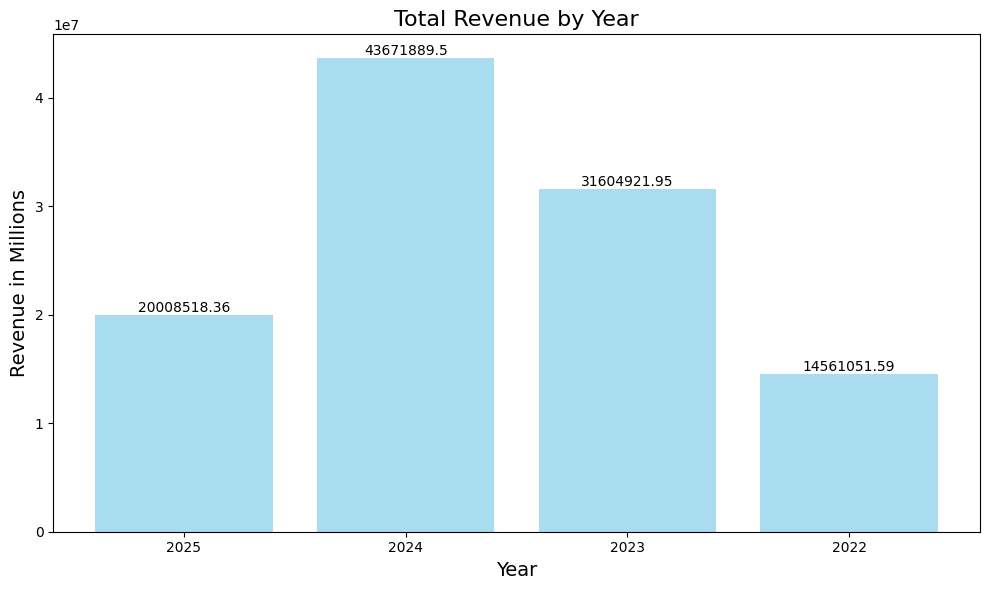

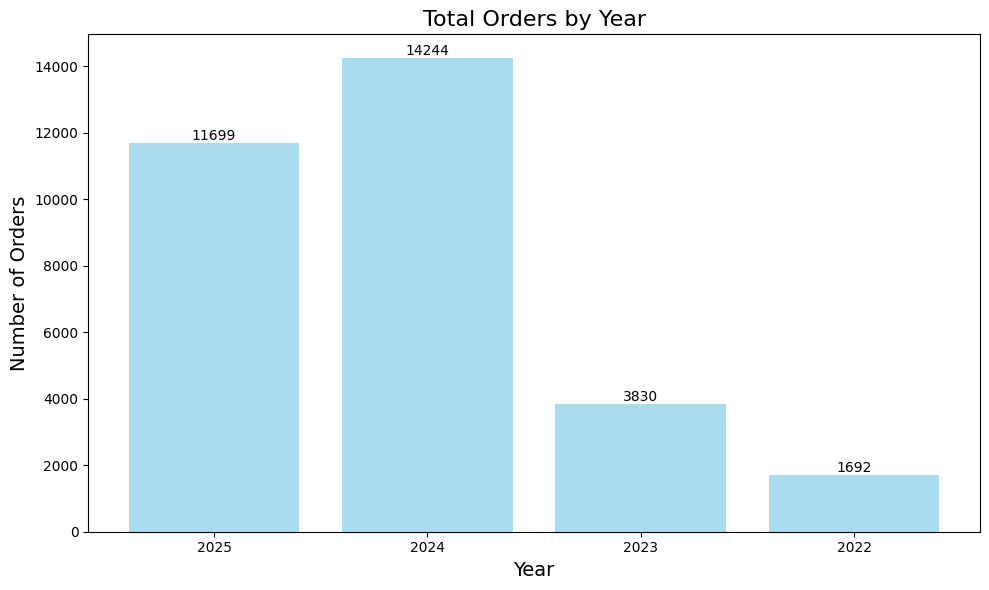

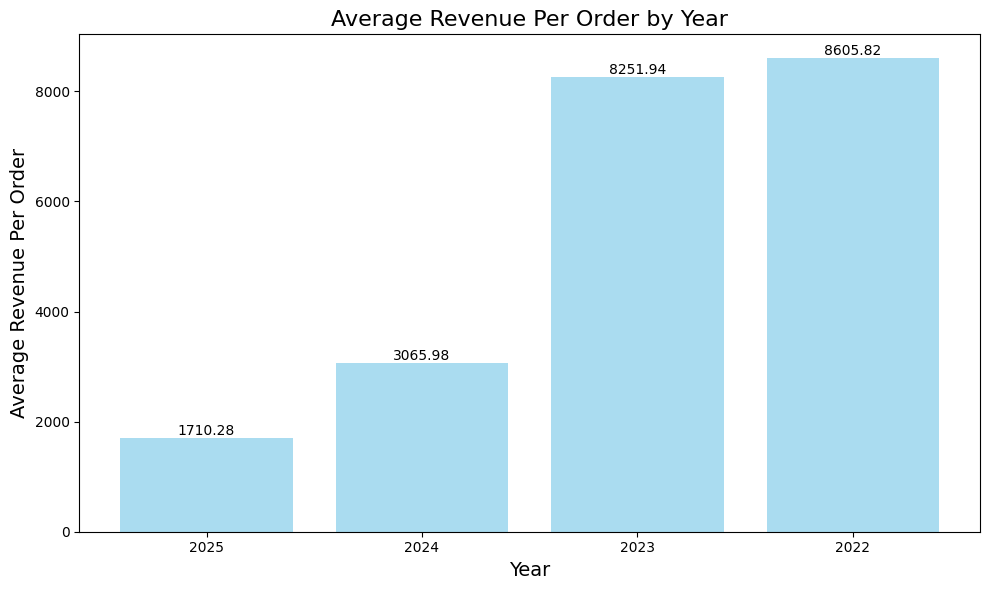

In [13]:
query_vis4 = """
SELECT
    YEAR(OrderDate) AS Year,
    COUNT(*) AS TotalOrders,
    ROUND(SUM(SubTotal),2) AS TotalRevenue,
    (SUM(SubTotal)) / COUNT(*) AS AverageRevenuePerOrder
    
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY Year DESC
"""

df_vis4 = query_df(query_vis4)
display(df_vis4)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df_vis4['Year'].astype(str), df_vis4['TotalRevenue'], color='skyblue',alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

ax.set_title('Total Revenue by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Revenue in Millions', fontsize=14)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df_vis4['Year'].astype(str), df_vis4['TotalOrders'], color='skyblue',alpha=0.7)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')
ax.set_title('Total Orders by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=14)  
ax.set_ylabel('Number of Orders', fontsize=14)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df_vis4['Year'].astype(str), df_vis4['AverageRevenuePerOrder'], color='skyblue',alpha=0.7)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')       
ax.set_title('Average Revenue Per Order by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Average Revenue Per Order', fontsize=14)
plt.tight_layout()
plt.show()



## Insikter - Försäljning och antal ordrar per år

Resultaten visar tydliga variationer mellan åren 2022 och 2025. Antalet order når sitt **maximala värde år 2024 med 14 244 order**, medan **minimivärdet återfinns år 2022 med 1 692 order**. Den totala intäkten är som **högst år 2024 med 43,7 MSEK** och som **lägst år 2022 med 14,6 MSEK**.

Den genomsnittliga intäkten per order uppvisar ett motsatt mönster, där **maximivärdet noteras år 2022 (8 605,82)** och **minimivärdet år 2025 (1 710,28)**. Det bör noteras att **data för år 2025 endast avser de första sex månaderna**, vilket kan påverka jämförbarheten med övriga år. Sammantaget indikerar resultaten en ökning i ordervolym över tid, samtidigt som den genomsnittliga intäkten per order har minskat.

## Visualisering 5: Top 10 produkter
Vilka 10 produkter genererar mest försäljning?

Tabeller som används:
Production.Product
Sales.SalesOrderDetail
Production.ProductCategory

Plan:
Räkna intäker per produkt
Filtrera de TOP 10 produkter
Skapa Horisontellt stapeldiagram
Analysera resultatet

• Sortera staplar från högst till lägst (högsta överst)


,QuantitySold,TotalRevenue,ProductName,Categorie
0,2977,4400592.80,"Mountain-200 Black, 38",Bikes
1,2664,4009494.76,"Mountain-200 Black, 42",Bikes
2,2394,3693678.03,"Mountain-200 Silver, 38",Bikes
3,2234,3438478.86,"Mountain-200 Silver, 42",Bikes
4,2216,3434256.94,"Mountain-200 Silver, 46",Bikes
5,2111,3309673.22,"Mountain-200 Black, 46",Bikes
6,1642,2516857.31,"Road-250 Black, 44",Bikes
7,1498,2347655.95,"Road-250 Black, 48",Bikes
8,1245,2012447.78,"Road-250 Black, 52",Bikes
9,664,1847818.63,"Road-150 Red, 56",Bikes


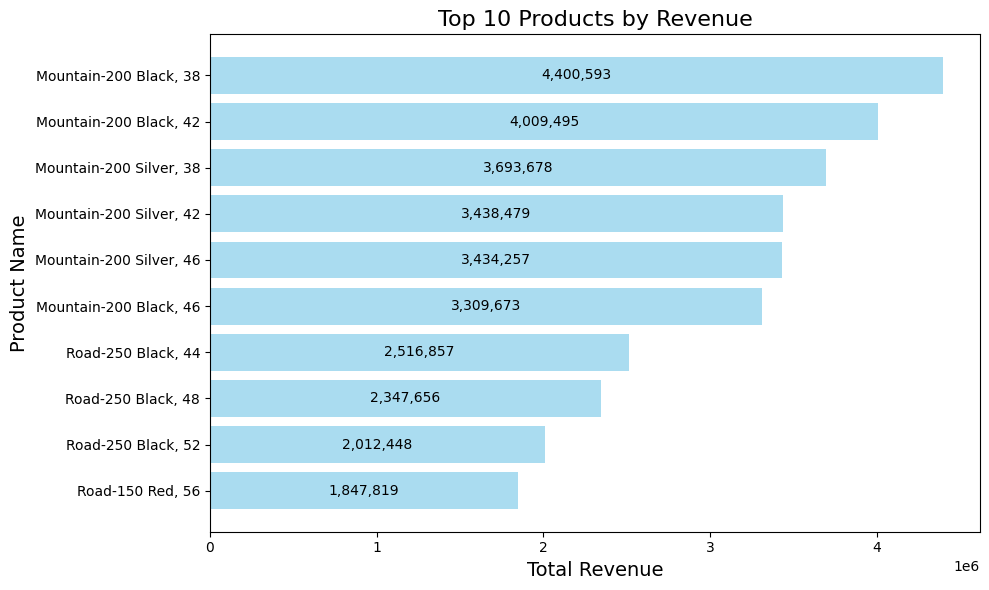

In [26]:
query_vis5 = """
SELECT TOP 10
    SUM(sod.OrderQty) AS QuantitySold,
    ROUND(SUM(sod.LineTotal), 2) AS TotalRevenue,
    p.Name AS ProductName,
    pc.Name AS Categorie
    
FROM Sales.SalesOrderDetail sod 
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY p.Name, pc.Name
ORDER BY TotalRevenue DESC 
"""

df_vis5 = query_df(query_vis5)
display(df_vis5)

df_sorted = df_vis5.sort_values(by='TotalRevenue', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(
    df_sorted['ProductName'],
    df_sorted['TotalRevenue'],
    color='skyblue',
    alpha=0.7
)

ax.set_title('Top 10 Products by Revenue', fontsize=16)
ax.set_ylabel('Product Name', fontsize=14)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width / 2,
        bar.get_y() + bar.get_height() / 2,
        f"{width:,.0f}",
        ha='center',
        va='center',
        color='black',
        fontsize=10
    )

ax.set_xlabel('Total Revenue', fontsize=14)
plt.tight_layout()
plt.show()


## Insikter - Top 10 produkter

Resultaten visar att samtliga topprodukter tillhör kategorin **Bikes**, vilket indikerar en tydlig dominans för denna kategori.

Den **högsta totala intäkten** genereras av **Mountain-200 Black, 38 med 4 400 592,80**, medan den **lägsta totala intäkten** återfinns för **Road-150 Red, 56 med 1 847 818,63**. Sammantaget dominerar modellerna i serien **Mountain-200** både i försäljningsvolym och intäktsbidrag jämfört med övriga produkter i urvalet.

Den **högsta sålda kvantiteten** uppnås av **Mountain-200 Black, 38 med 2 977 enheter**, medan den **lägsta sålda kvantiteten** noteras för **Road-150 Red, 56 med 664 enheter**.

## Visualisering 6: Försäljning och antal kunder per region
Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

Tabeller som används:
Sales.SalesTerritory
Sales.SalesOrderHeader
Sales.Customer

Plan:
Räkna försälning per region
Räkna antal unika kunder per region
Grupperat stapeldiagram (grouped bar) med två staplar per region
Analysera resultatet

• Typ: Grupperat stapeldiagram (grouped bar) med två staplar per region
•Titel: "Försäljning och antal kunder per region"
• En stapel för försäljning, en stapel för antal kunder
• Sortera regioner från högst försäljning
Krav på insikt:
• Vilken region är starkast/svagast? Jämför: Har regionen med högst försäljning också flest kunder, eller har de färre kunder med högre ordervärde? Vad betyder det?


,TerritoryName,TotalRevenue,AmountOfUniqueCustomer
0,Southwest US,24184609.60,4565
1,Canada CA,16355770.46,1677
2,Northwest US,16084942.55,3428
3,Australia AU,10655335.96,3625
4,Central US,7909009.01,69
5,Southeast US,7879655.07,91
6,United Kingdom GB,7670721.04,1951
7,France FR,7251555.65,1844
8,Northeast US,6939374.48,57
9,Germany DE,4915407.60,1812


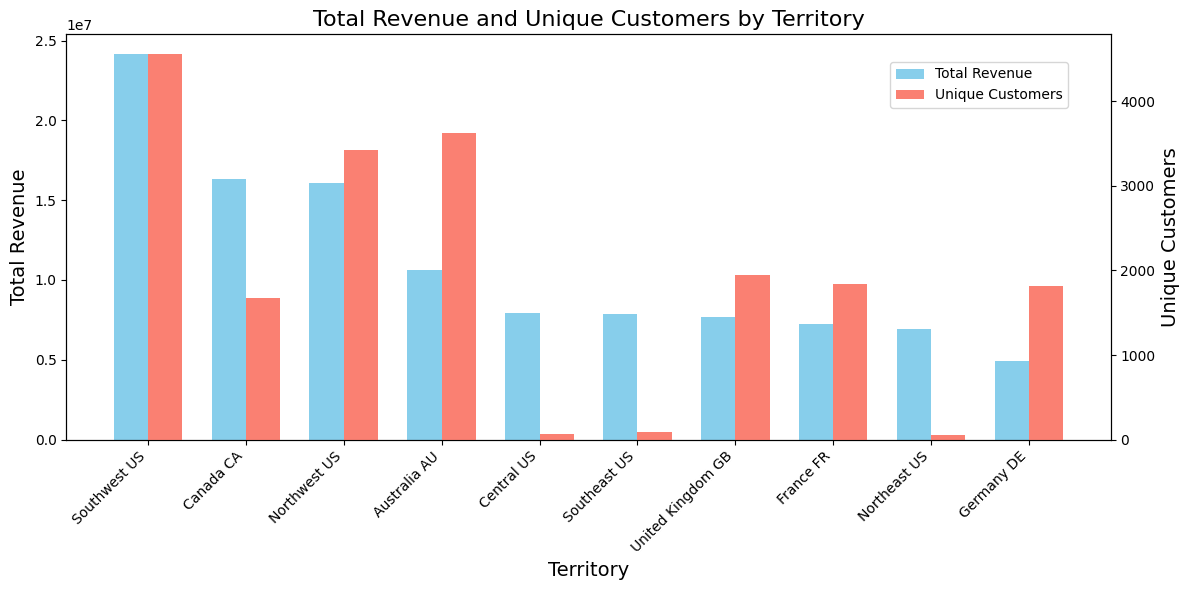

In [31]:
query_vis6 = """
SELECT
    CONCAT(sst.Name,' ',sst.CountryRegionCode) AS TerritoryName,
    ROUND(SUM(soh.SubTotal),2) AS TotalRevenue,
    COUNT(DISTINCT c.CustomerID) AS AmountOfUniqueCustomer
      
    
FROM Sales.SalesOrderHeader soh 
INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
INNER JOIN Sales.SalesTerritory sst ON c.TerritoryID = sst.TerritoryID
GROUP BY sst.Name, sst.CountryRegionCode
ORDER BY TotalRevenue DESC
 
"""

df_vis6 = query_df(query_vis6)
display(df_vis6)

territories = df_vis6['TerritoryName']
revenue = df_vis6['TotalRevenue']
customers = df_vis6['AmountOfUniqueCustomer']

x = np.arange(len(territories))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

bars1 = ax1.bar(
    x - width/2,
    revenue,
    width,
    label='Total Revenue',
    color='skyblue'
)

bars2 = ax2.bar(
    x + width/2,
    customers,
    width,
    label='Unique Customers',
    color='salmon'
)

ax1.set_title('Total Revenue and Unique Customers by Territory', fontsize=16)
ax1.set_xlabel('Territory', fontsize=14)
ax1.set_ylabel('Total Revenue', fontsize=14)
ax2.set_ylabel('Unique Customers', fontsize=14)

ax1.set_xticks(x)
ax1.set_xticklabels(territories, rotation=45, ha='right')

# Combined legend
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()

## Insikter - Försäljning och antal kunder per region

Analysen visar tydliga skillnader mellan regionerna när det gäller både total försäljning och antal unika kunder. **Southwest US** framstår som den starkaste regionen, med **högst total försäljning (24,2 MSEK)** och samtidigt **flest unika kunder (4 565)**. Detta indikerar en bred och stabil kundbas där försäljningsvolymen drivs av många kunder snarare än enbart höga ordervärden.

Den **svagaste regionen sett till total försäljning** är **Germany DE** med **4,9 MSEK**, trots ett relativt högt antal unika kunder (**1 812**). Detta tyder på ett **lägre genomsnittligt ordervärde** jämfört med flera andra regioner.

Vid en jämförelse mellan regioner framgår att den region som har högst försäljning **inte alltid** är den som har flest kunder. Exempelvis har **Canada CA** och **Northwest US** en hög total försäljning (**16,4 MSEK respektive 16,1 MSEK**) trots betydligt färre kunder än Southwest US, vilket indikerar **högre ordervärde per kund**. 

Samtidigt uppvisar **Central US**, **Southeast US** och **Northeast US** mycket låga kundantal (**57–91 kunder**) i relation till sin försäljning, vilket tyder på att intäkterna i dessa regioner sannolikt drivs av **ett fåtal kunder med mycket höga ordervärden**. Detta innebär en potentiellt hög risk, då försäljningen kan vara mer sårbar om enskilda kunder försvinner.

Sammanfattningsvis visar analysen att regioner med många kunder skapar stabilitet genom volym, medan regioner med färre kunder men relativt hög försäljning indikerar högre ordervärden per kund, men också en ökad affärsrisk.